In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

In [3]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels, all_chemical_names):
    """
    Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

    Args:
    - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - output_embeddings (list): Encoder output embeddings.
    - output_labels (list): Chemical names for each embedding in the encoder's output.
    - all_chemical_names (list): Sorted list of all chemical names in the training data.
    """
    
    pca = PCA(n_components=2)
    pca.fit(all_embeddings.T)

    true_embeddings = [all_embeddings[chem] for chem in all_chemical_names]    
    true_transformed = pca.transform(true_embeddings)

    output_transformed = pca.transform(output_embeddings)

    color_map = {chem: idx for idx, chem in enumerate(all_chemical_names)}

    # Map labels to colors for both true and output embeddings
    true_colors = [color_map[chem] for chem in all_chemical_names]
    output_colors = [color_map[chem] for chem in output_labels]

    true_x = [pair[0] for pair in true_transformed]
    true_y = [pair[1] for pair in true_transformed]
    scatter = plt.scatter(true_x, true_y, c=true_colors, cmap='tab20')

    unique_labels = sorted(list(set(output_labels)))
    output_x = [pair[0] for pair in output_transformed]
    output_y = [pair[1] for pair in output_transformed]
    plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

    plt.legend(handles=scatter.legend_elements()[0],
                labels=unique_labels,
                loc='upper right',
                prop={'size':7})


    plt.title('Chemception Embeddings vs. Denoiser Output')
    plt.xticks([])
    plt.yticks([])

    plt.show()

In [4]:
def get_weighted_cosine_similarity(output, target):
  # it is common to use m/z ratio as weights since fragments with higher m/z ratios are more important.
  mz = torch.arange(1, len(target)+1)

  numerator = torch.sum(mz*output*target)
  output_denom = torch.sqrt(torch.sum(mz*output**2))
  target_denom = torch.sqrt(torch.sum(mz*target**2))

  weighted_cosine_similarity = numerator/(output_denom*target_denom)
  return(weighted_cosine_similarity)

In [5]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0.5):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()
      input_max = max(input_frequencies)
      scaled_input = [num/input_max * 100 for num in input_frequencies]

      out_clone = fake_spec.copy()
      output_max = max(out_clone)
      scaled_out = [num/output_max * 100 for num in out_clone]
      out_frequencies = [0 if num < cutoff else num for num in scaled_out]

      weighted_cosine_similarity = get_weighted_cosine_similarity(out_clone, input_frequencies)

      _, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, scaled_input[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      print('Weighted cosine similarity is: ', round(float(weighted_cosine_similarity), 2))
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [6]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    # generate a list of random indices of len = noise_pct% of target location and change values at each index to 0
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = 0
    input_list.append(input_spectra)

    condition_encodings = spectra[list(columns)][-12:].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = 0
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = 0
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        labels.append(list(spectra[col][915:-12]))
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    # shifting to make all data positive
    min_value = 1
    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    input_data += min_value
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    all_true_vals += min_value
    # log transforming data to reduce impact of different scales 
    input_normed = torch.log(input_data)
    trues_normed = torch.log(all_true_vals)
    input_data = TensorDataset(input_normed, trues_normed, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [7]:
def create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if test_chem in col]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  for col in all_test_chem_columns:
    instrument_encoding = list(spectra[col][-12:])
    # filter out the test instrument type
    if instrument_encoding.index(1) == instrument_idx:
      test_cols.append(col)

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)

  return train_input, test_input

In [8]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.denoiser = nn.Sequential(
      nn.Linear(1439,1439),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1439,1439),
    )

    self.optimizer = torch.optim.AdamW(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [9]:
def get_loss(model, true_vals, output_0, output_1, output_2, start_idx, end_idx):
    true_data = true_vals[:,start_idx:end_idx]
    output_data_0 = output_0[:, start_idx:end_idx]
    output_data_1 = output_1[:, start_idx:end_idx]
    output_data_2 = output_2[:, start_idx:end_idx]

    m_0_loss = model.criterion(output_data_0, true_data)
    m_1_loss = model.criterion(output_data_1, true_data)
    m_2_loss = model.criterion(output_data_2, true_data)
    loss = m_0_loss + m_1_loss + m_2_loss 
    return loss

In [10]:
def train_denoiser(model, data, test_data, sorted_chemical_names, epochs, train_loss_log = [], test_loss_log = []):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        with torch.no_grad(): 
            test_loss = 0
            for batch, true_vals, labels in test_data:
                output_0= model(batch)
                output_1= model(output_0)
                output_2= model(output_1)
                m_0_loss = model.criterion(output_0, true_vals)
                m_1_loss = model.criterion(output_1, true_vals)
                m_2_loss = model.criterion(output_2, true_vals)

                loss = m_0_loss + m_1_loss + m_2_loss
                test_loss += loss 

            average_test_loss = test_loss/len(test_data)
            
        # accumulate epoch output and loss
        epoch_training_loss = 0
        epoch_spec_loss = 0
        epoch_cond_loss = 0
        epoch_emb_loss = 0
        for batch, true_vals, labels in data:
            output_0= model(batch)
            output_1= model(output_0)
            output_2= model(output_1)
            
            spec_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=0, end_idx=915)
            epoch_spec_loss+=spec_loss
            cond_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=915, end_idx=927)
            epoch_cond_loss+=cond_loss
            emb_loss = get_loss(model, true_vals, output_0, output_1, output_2, start_idx=927, end_idx=1439)
            epoch_emb_loss+=emb_loss

            m_0_loss = model.criterion(output_0, true_vals)
            m_1_loss = model.criterion(output_1, true_vals)
            m_2_loss = model.criterion(output_2, true_vals)
            
            loss = m_0_loss + m_1_loss + m_2_loss
            epoch_training_loss += loss

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
                    # undo log transformation
                    denoised_vector = torch.exp(denoised_vector) - 1
                    model_output.append(denoised_vector)
                    true_val = torch.exp(true_val) - 1 
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)
        

        average_loss = epoch_training_loss/len(data)
        avg_spec_loss = epoch_spec_loss/len(data)
        avg_cond_loss = epoch_cond_loss/len(data)
        avg_emb_loss = epoch_emb_loss/len(data)

        train_loss_log.append(average_loss.detach().numpy())
        test_loss_log.append(average_test_loss.detach().numpy())
        
        if (epoch+1) % 10 == 0:
            print('Epoch[{}/{}], train loss: {}, test loss: {}'.format(epoch+1, epochs, round(float(average_loss.detach().numpy()), 6), round(float(average_test_loss.detach().numpy()), 6)))
            print(f'Spec: {round(float(avg_spec_loss.detach().numpy()), 6)}, Cond: {round(float(avg_cond_loss.detach().numpy()), 6)}, Emb: {round(float(avg_emb_loss.detach().numpy()), 6)}')
            print('--------------------------------------------------------')

    return model_output, output_labels, true_vals_output, train_loss_log, test_loss_log

In [11]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [12]:
loss_type = 'spectra'
train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=loss_type, noise_pct=1)

In [13]:
# noise_loc = 'spectra'
# train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=noise_loc, noise_pct=1)
denoiser = Denoiser()
model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=200, train_loss_log = [], test_loss_log = [])

Epoch[10/200], train loss: 0.208372, test loss: 0.141834
Spec: 0.289429, Cond: 0.074265, Emb: 0.066657
--------------------------------------------------------
Epoch[20/200], train loss: 0.169829, test loss: 0.104341
Spec: 0.248382, Cond: 0.065446, Emb: 0.031891
--------------------------------------------------------
Epoch[30/200], train loss: 0.15201, test loss: 0.102272
Spec: 0.227032, Cond: 0.057827, Emb: 0.020145
--------------------------------------------------------
Epoch[40/200], train loss: 0.142981, test loss: 0.103364
Spec: 0.215707, Cond: 0.054799, Emb: 0.015077
--------------------------------------------------------
Epoch[50/200], train loss: 0.135433, test loss: 0.09865
Spec: 0.205412, Cond: 0.049964, Emb: 0.012377
--------------------------------------------------------
Epoch[60/200], train loss: 0.128135, test loss: 0.097134
Spec: 0.19536, Cond: 0.044253, Emb: 0.009961
--------------------------------------------------------
Epoch[70/200], train loss: 0.120667, test l

In [57]:
# get values for test spectra 
spec_num = 1
# true_spectra = [vec[:915].detach().numpy() for vec in true_values]
# scaled_spec = true_spectra[spec_num]
output_spectra = [vec[:915].detach().numpy() for vec in model_output]
fake_spec = output_spectra[spec_num]
max_val = max(fake_spec)
# scaled_out = [num/output_max * 100 for num in out_clone]
# out_frequencies = [0 if num < cutoff else num for num in scaled_out]


scaled_spec = [num/max_val * 100 for num in fake_spec]
cutoff=.
scaled_spec = [0 if num < cutoff else num for num in scaled_spec]
for i, num in enumerate(scaled_spec):
  if num > 0:
    print(i+1, round(float(num), 4))

15 0.3486
43 0.4997
44 0.3367
60 0.9081
61 0.483
66 0.675
69 0.3209
72 0.5143
73 2.0437
74 0.9838
75 1.2314
85 0.9714
86 0.4853
87 2.5496
88 0.975
89 0.9485
93 0.4677
97 0.3092
99 7.9798
100 1.0214
101 3.3863
102 1.0054
103 1.863
104 0.3315
105 0.8561
109 1.3134
110 0.3169
113 0.3697
115 1.8009
116 1.6971
117 2.8304
118 0.4262
119 0.853
131 5.6499
132 0.9081
133 7.0138
134 1.2977
135 0.8447
143 4.3226
144 0.3667
147 100.0
148 14.5273
149 8.8721
150 1.2635
158 0.5564
159 0.429
163 0.4828
173 1.025
174 0.3098
189 1.0211
190 0.3892
217 1.1792
221 1.0529
222 0.6477
223 0.466
231 0.5263
232 0.3133
233 4.3831
234 1.0801
235 0.5979
248 0.7287
305 0.9755
306 0.5057
307 0.4613


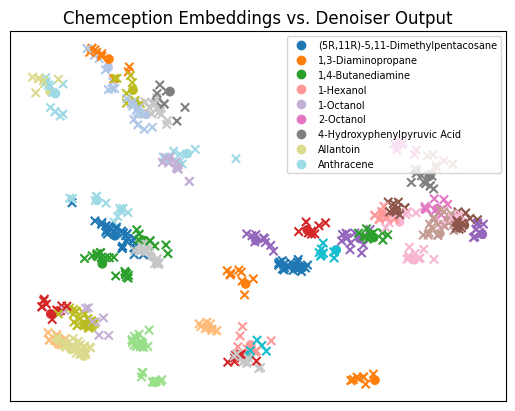

In [14]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

Weighted cosine similarity is:  1.0


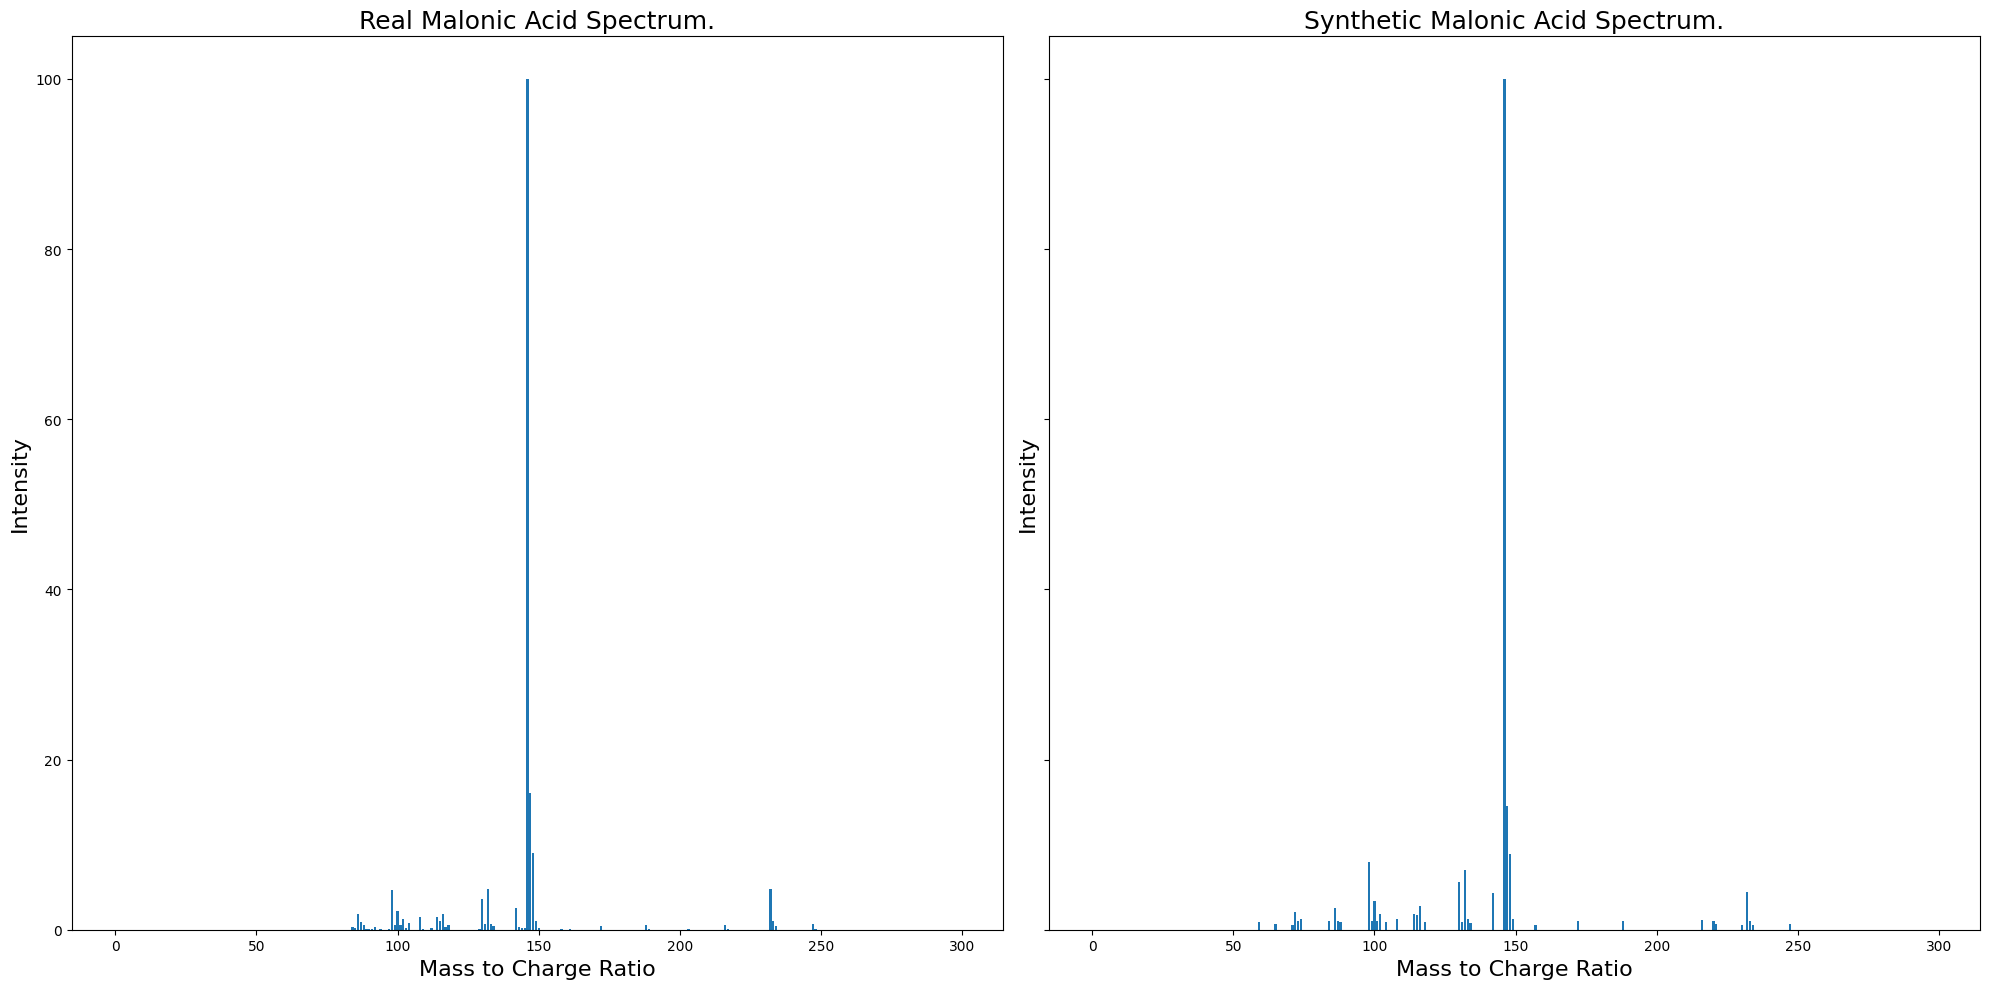

In [52]:
true_spectra = [vec[:915].detach().numpy() for vec in true_values]
output_spectra = [vec[:915].detach().numpy() for vec in model_output]
plot_results(true_spectra, output_spectra, output_labels, idx=[1,2])

In [16]:
# noise_loc = 'spectra'
# train_noisy_data, test_noisy_data = create_dataset(spectra, embeddings, noise_loc=noise_loc, noise_pct=1)
# denoiser = Denoiser()
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=200, train_loss_log = [], test_loss_log = [])

In [17]:
# # create x-axis values
# epochs = range(1, len(train_loss_log) + 1)

# # plot train and test loss
# plt.plot(epochs, train_loss_log, 'b', label='Training loss')
# plt.plot(epochs, test_loss_log, 'r', label='Testing loss')
# plt.legend()
# plt.show()

In [18]:
# denoiser.optimizer = torch.optim.AdamW(denoiser.parameters(), lr=.00001)
# model_output, output_labels, true_values, train_loss_log, test_loss_log = train_denoiser(denoiser, train_noisy_data, test_noisy_data, all_chemical_names, epochs=100, train_loss_log=train_loss_log, test_loss_log=test_loss_log)

In [19]:
# output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
# plot_emb_pca(embeddings, output_embeddings, output_labels, all_chemical_names)

In [20]:
# denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_tmp.pth'
# torch.save(denoiser.state_dict(), denoiser_path)

In [21]:
denoiser.eval()
test_output = []
test_labels = []
test_true_values = []
test_loss = 0

with torch.no_grad(): 
    for batch, true_vals, labels in test_noisy_data:
        output_0= denoiser(batch)
        output_1= denoiser(output_0)
        output_2= denoiser(output_1)

        m_0_loss = denoiser.criterion(output_0, true_vals)
        m_1_loss = denoiser.criterion(output_1, true_vals)
        m_2_loss = denoiser.criterion(output_2, true_vals)

        loss = m_0_loss + m_1_loss + m_2_loss
        test_loss+=loss

    chem_names = [all_chemical_names[list(encoding).index(1)] for encoding in labels]
    for denoised_vector, chem_name, true_val in zip(output_2, chem_names, true_vals):
        # undo log transformation
        denoised_vector = torch.exp(denoised_vector) - 1
        test_output.append(denoised_vector)
        true_val = torch.exp(true_val) - 1 
        test_true_values.append(true_val)
        test_labels.append(chem_name)

    average_loss = test_loss/len(test_noisy_data)
    print('Loss =', average_loss)

Loss = tensor(0.1004)


Weighted cosine similarity is:  0.9


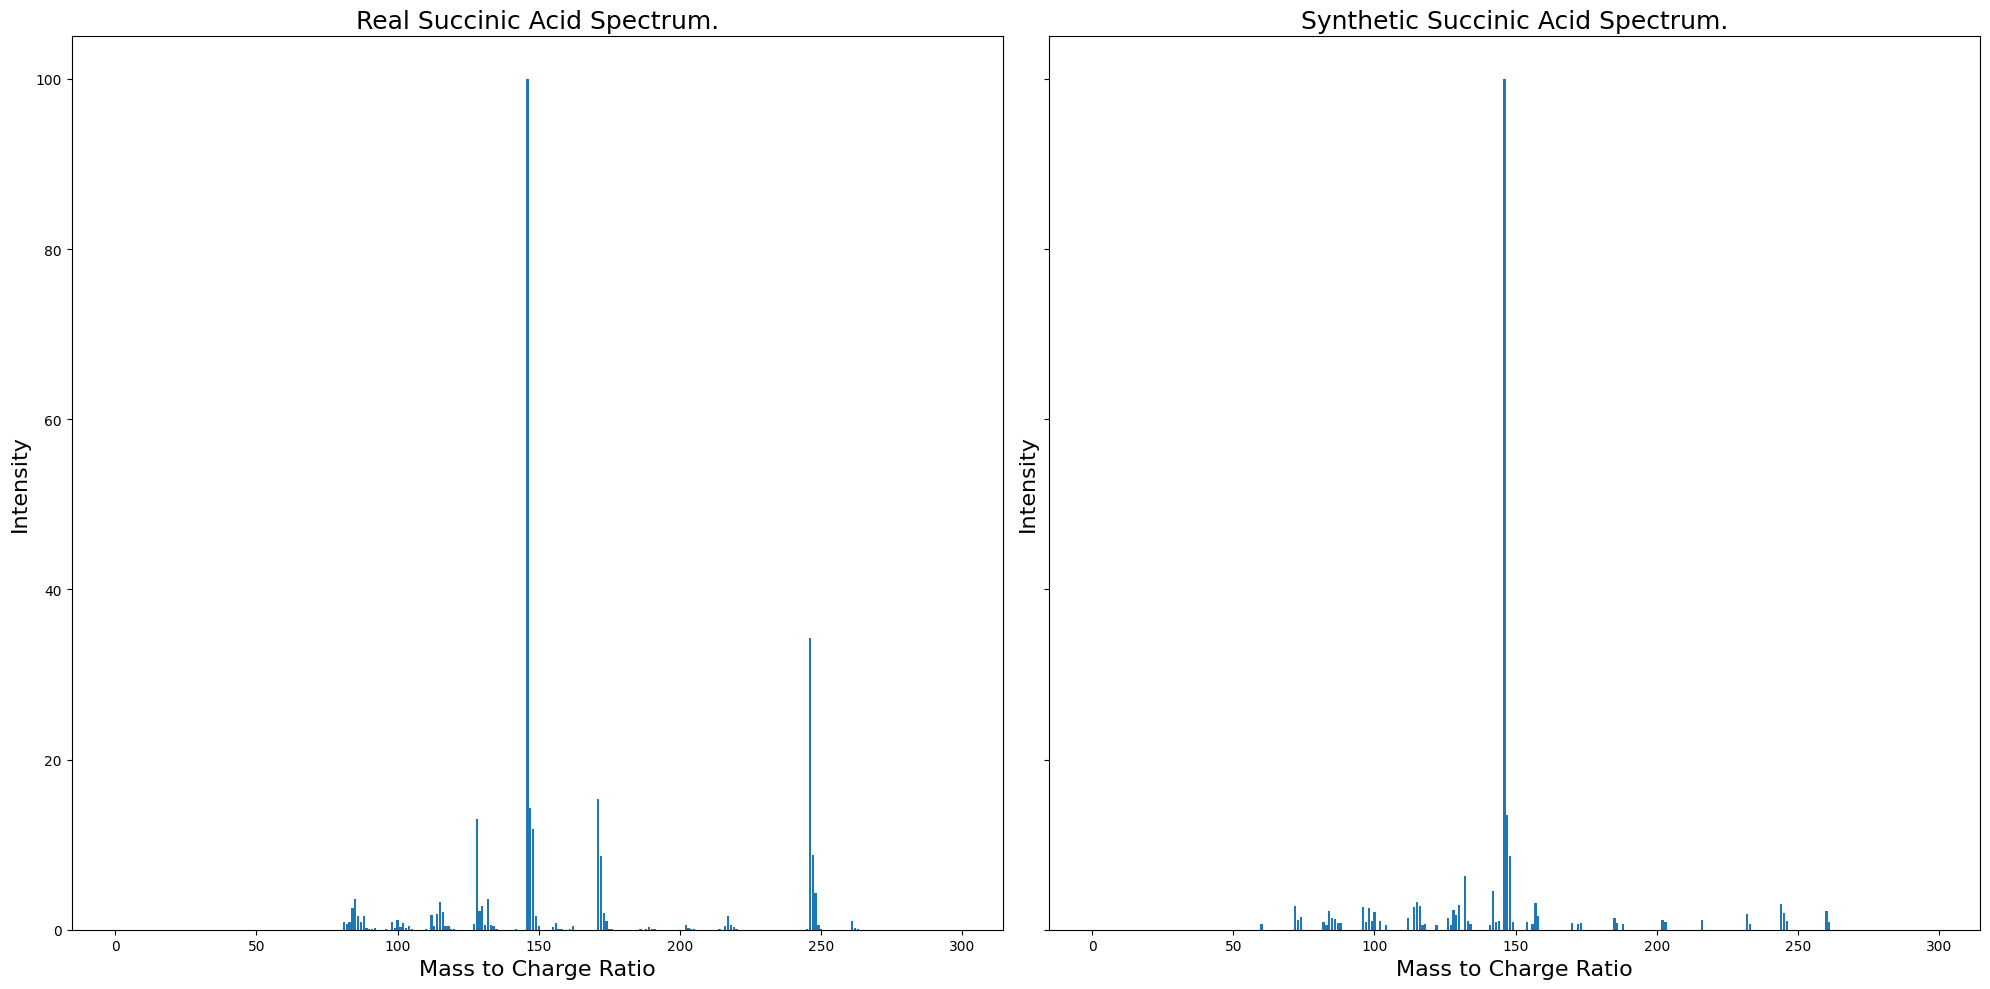

Weighted cosine similarity is:  0.83


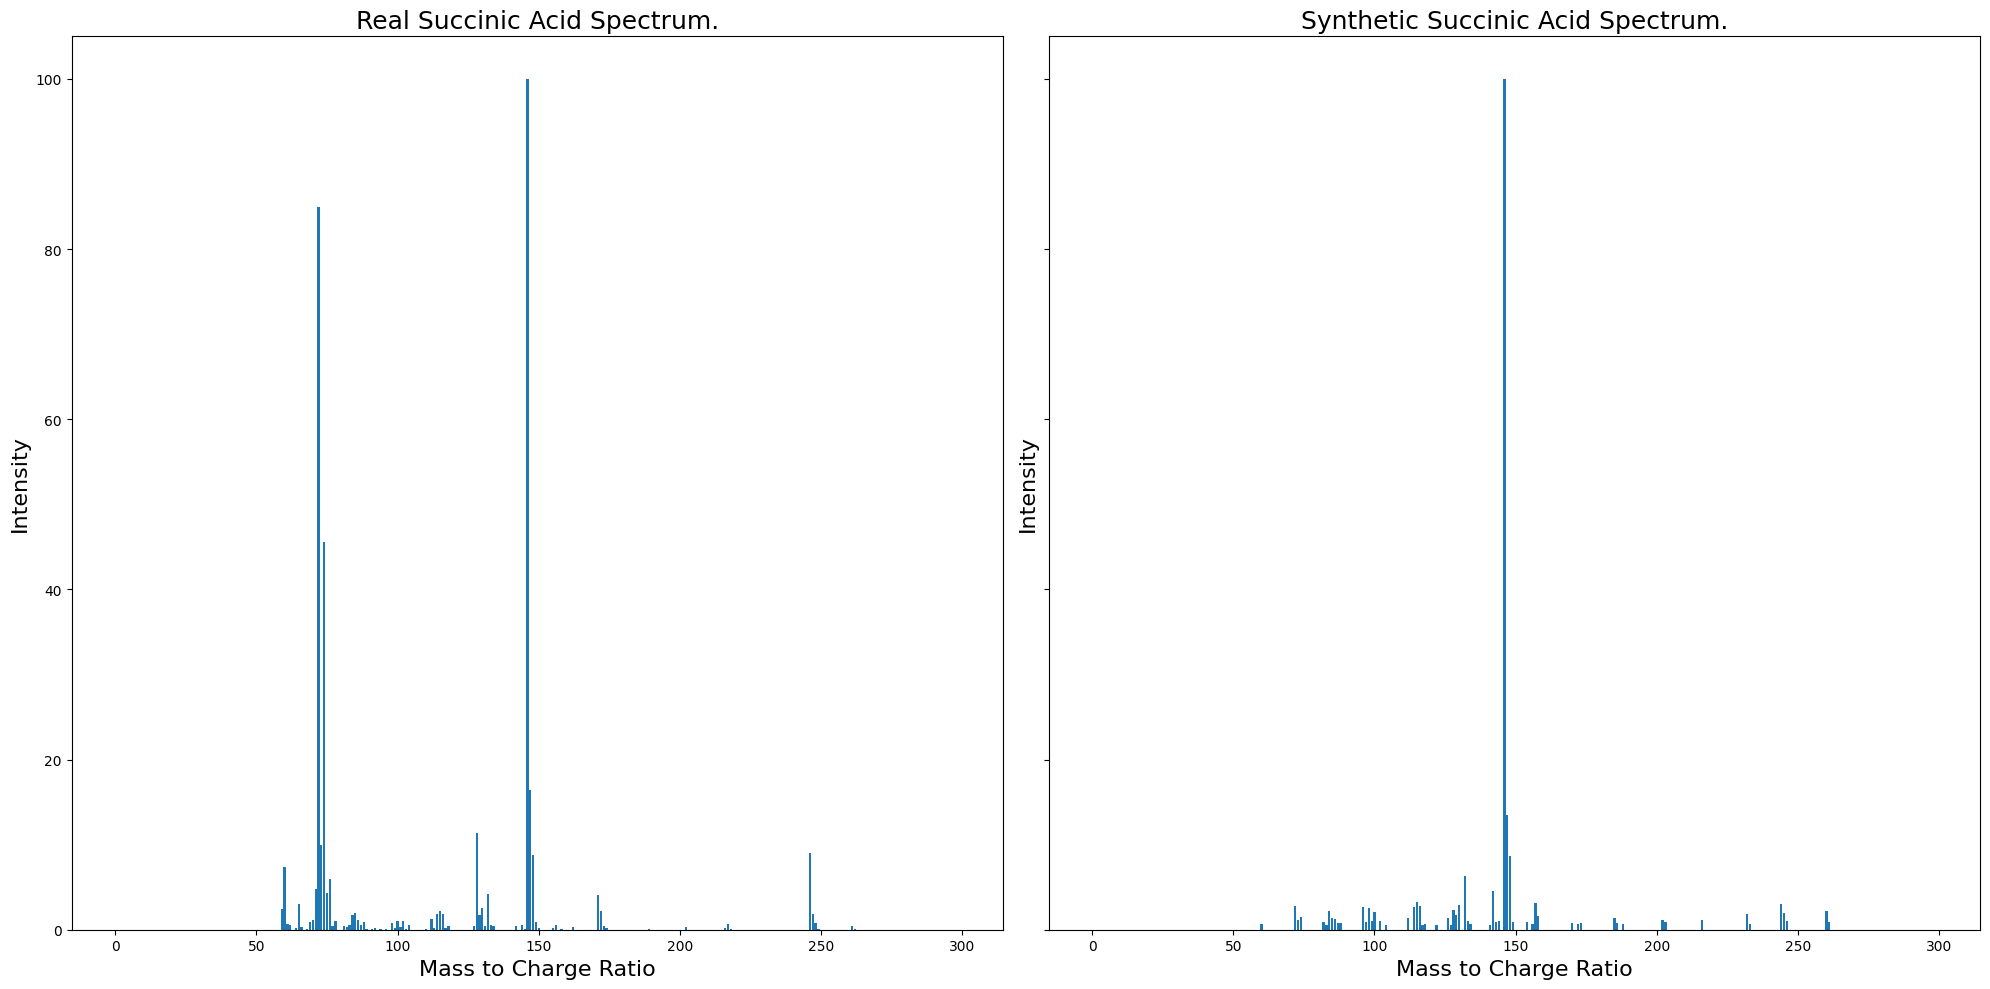

Weighted cosine similarity is:  0.98


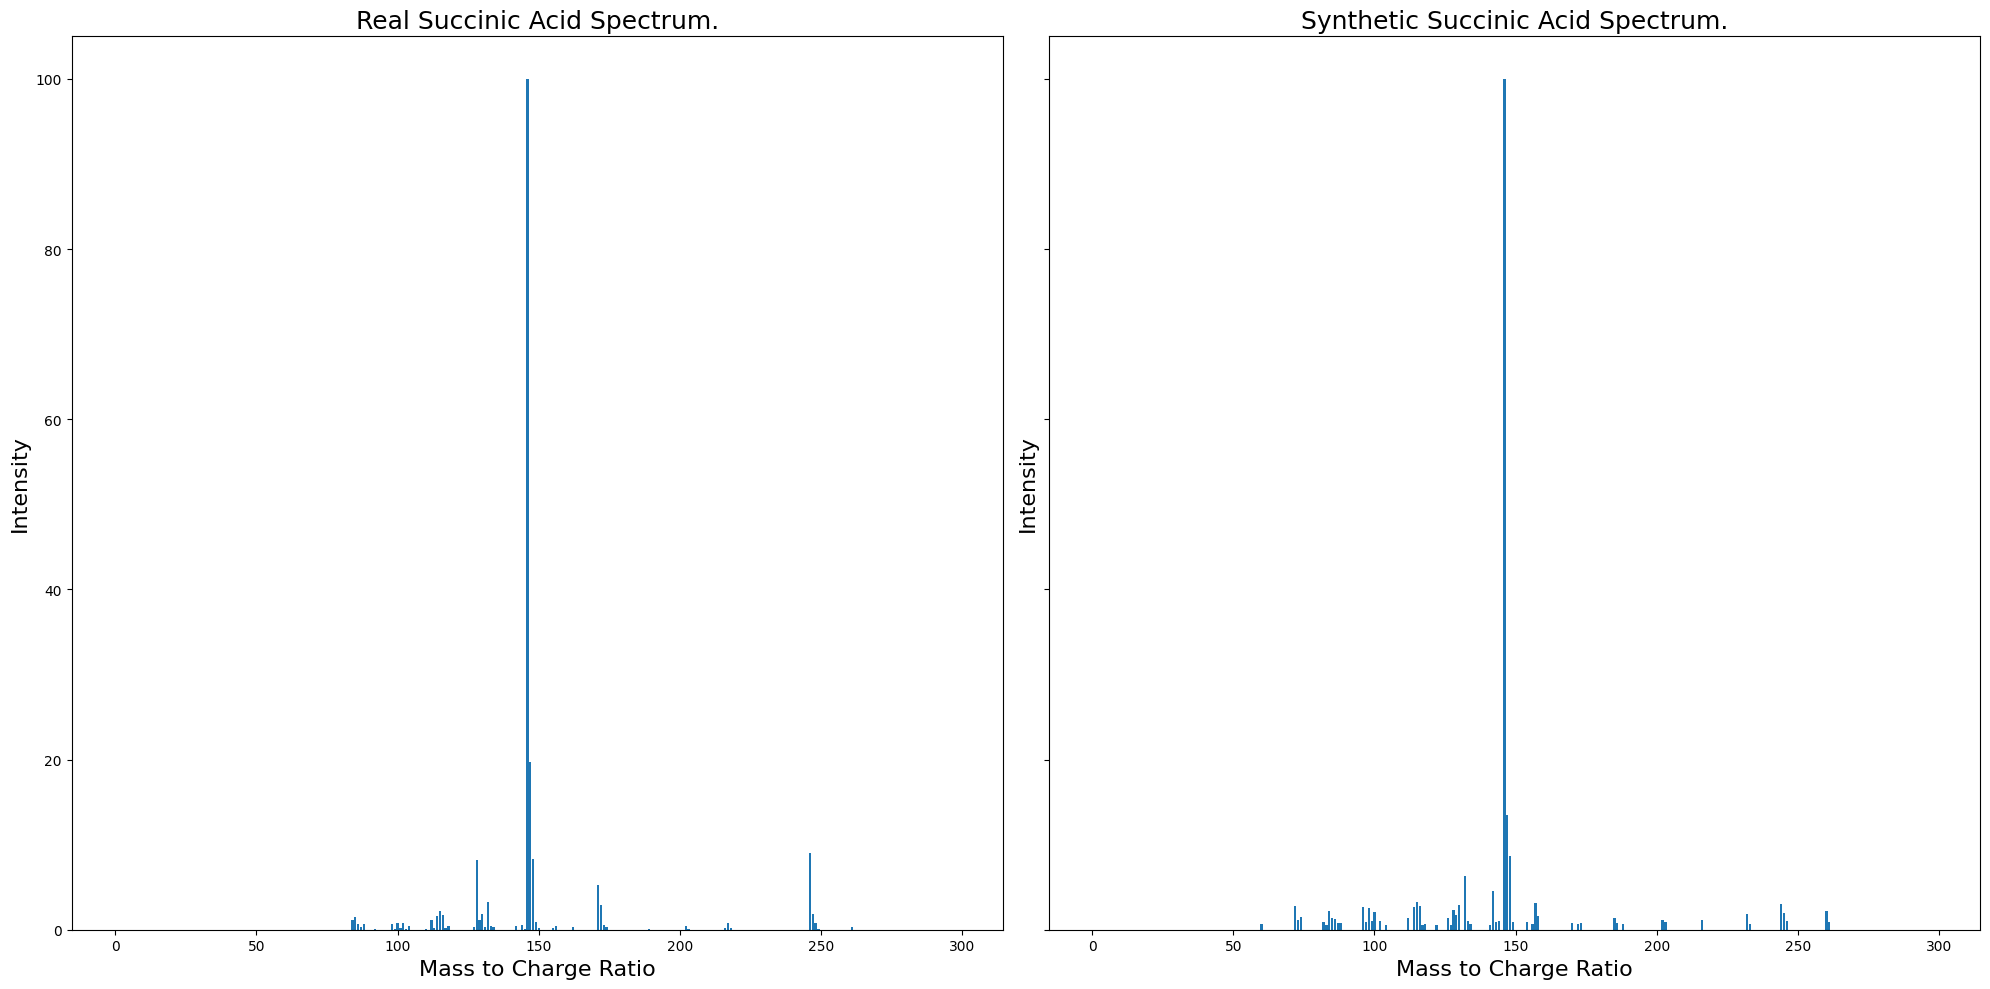

In [60]:
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
output_spectra = [vec[:915].detach().numpy() for vec in test_output]
plot_results(true_spectra, output_spectra, test_labels, idx=[0,3])

In [59]:
# test_output_embeddings = [vec[-512:].detach().numpy() for vec in test_output]
# # plot_emb_pca(embeddings, test_output_embeddings, test_labels, train_chems)
# plot_emb_pca(embeddings, test_output_embeddings, test_labels, all_chemical_names)

In [24]:
# get values for test spectra 
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
true_spectra = [vec[:915].detach().numpy() for vec in test_true_values]
fake_spec = true_spectra[2]
# output_spectra = [vec[:915].detach().numpy() for vec in test_output]
# fake_spec = output_spectra[0]
max_val = max(fake_spec)
# print(max_val)
# print(min(fake_spec))
scaled_spec = [num/max_val * 100 for num in fake_spec]
scaled_spec = [num if num >= 0 else 0 for num in scaled_spec]
# print(min(scaled_spec))
for i, num in enumerate(scaled_spec):
  if num > 0:
    print(i+1, round(float(num), 4))

85 1.2012
86 1.5015
87 0.7007
88 0.3003
89 0.7007
93 0.1001
99 0.7007
100 0.1001
101 0.8008
102 0.2002
103 0.8008
104 0.1001
105 0.4004
111 0.1001
113 1.2012
114 0.2002
115 1.6016
116 2.2022
117 1.7017
118 0.2002
119 0.4004
128 0.3003
129 8.2082
130 1.2012
131 1.9019
132 0.3003
133 3.3033
134 0.4004
135 0.3003
143 0.4004
145 0.5005
146 0.1001
147 100.0
148 19.7197
149 8.3083
150 0.9009
151 0.2002
156 0.2002
157 0.4004
163 0.3003
172 5.3053
173 2.9029
174 0.5005
175 0.3003
190 0.1001
203 0.4004
204 0.1001
217 0.2002
218 0.8008
219 0.2002
247 9.009
248 1.8018
249 0.8008
250 0.1001
262 0.3003


# Generate embeddings and then spectra:
---

In [ ]:
# train_data = []
# true_data = []
# for true_val, pred_val in zip(true_values, model_output):
#     train_data_point = true_val
#     for i in enumerate(train_data_point[927:]):
#         train_data_point[i[0]+927] = pred_val[i[0]+927]
#     train_data.append(train_data_point.detach().clone().numpy())
#     true_data.append(true_val.detach().clone().numpy())
    
# # shifting to make all data positive
# min_value = 1
# input_data = torch.tensor(np.vstack((train_data)).T, dtype=torch.float)
# input_data += min_value
# all_true_vals = torch.tensor(np.vstack((true_data)).T, dtype=torch.float)
# all_true_vals += min_value
# # log transforming data to reduce impact of different scales 
# input_normed = torch.log(input_data)
# trues_normed = torch.log(all_true_vals)
# input_data = TensorDataset(input_normed, trues_normed, output_labels)

# batch_size=32
# # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
# input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)